In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Taxi fare prediction using the Chicago Taxi Trips dataset stored in Azure blob storage 

<table align="left">
  <td>
      <img src="MultiCloudML.png" alt="Architecture"> Architecture
  </td>                                                                                               
</table>

# Vertex AI (through BigQuery Omni) allows you to analyze data and develop, train, deploy Machine Learning models for the data stored in AWS, Azure and others, without needing to actually move the data, Saving Egress Fee)

## Overview

This notebook demonstrates analysis, feature selection, model building, and deployment with Explainable AI configured on Vertex AI, using a subset of the Chicago Taxi Trips dataset for taxi-fare prediction.

*Note: This notebook is developed to run in a [Vertex AI Workbench managed notebooks](https://console.cloud.google.com/vertex-ai/workbench/list/managed) instance using the Python (Local) kernel. Some components of this notebook may not work in other notebook environments.*

Learn more about [Vertex AI Workbench](https://cloud.google.com/vertex-ai/docs/workbench/introduction) and [Vertex Explainable AI](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview).

### Objective

The goal of this notebook is to provide an overview on the latest Vertex AI features like **Explainable AI** and **BigQuery in Notebooks** by trying to solve a taxi fare prediction problem. 


This tutorial uses the following Google Cloud ML services and resources:

- `Vertex AI Model` resource
- `Vertex AI Endpoint` resource
- `Vertex Explainable AI`
-  Google Cloud Storage
-  Azure Blob Storage
-  BigQuery Omni

The steps performed include:

- Loading the dataset using "BigQuery Omni in Notebooks".
- Performing exploratory data analysis on the dataset.
- Feature selection and preprocessing.
- Building a linear regression model using scikit-learn.
- Configuring the model for Vertex Explainable AI.
- Deploying the model to Vertex AI.
- Testing the deployed model.
- Clean up.

### Dataset

The Chicago Taxi Trips dataset includes taxi trips from 2013 to the present, reported to the city of Chicago in its role as a regulatory agency. To protect privacy but allow for aggregate analyses, the taxi ID is consistent for any given taxi medallion number but does not show the number, census tracts are suppressed in some cases, and times are rounded to the nearest 15 minutes. Due to the data reporting process, not all trips are reported but the city believes that most are. This dataset is publicly available on BigQuery as a public dataset with the table ID `bigquery-public-data.chicago_taxi_trips.taxi_trips` and also as a public dataset on Kaggle at [Chicago Taxi Trips](https://www.kaggle.com/chicago/chicago-taxi-trips-bq).

For more information about this dataset and how it was created, see the [Chicago Digital website](http://digital.cityofchicago.org/index.php/chicago-taxi-data-released).

The original dataset considered for this tutorial is a large and noisy one and so data from a specific date range will be used. Based on various online resources, the data from around May 2018 gave some really good results compared to the other date ranges. While there are also some complicated models proposed for the same problem, like considering the weather data, holidays and seasons, the current notebook only explores a simple linear regression model. Our main objective is to demonstrate the model deployment with Vertex Explainable AI configured on Vertex AI.

The chosen dataset consists of the following fields:

- `unique_key` : Unique identifier for the trip.
- `taxi_id` : A unique identifier for the taxi.
- `trip_start_timestamp`: When the trip started, rounded to the nearest 15 minutes.
- `trip_end_timestamp`: When the trip ended, rounded to the nearest 15 minutes.
- `trip_seconds`: Time of the trip in seconds.
- `trip_miles`: Distance of the trip in miles.
- `pickup_census_tract`: The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips.
- `dropoff_census_tract`: The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips.
- `pickup_community_area`: The Community Area where the trip began.
- `dropoff_community_area`: The Community Area where the trip ended.
- `fare`: The fare for the trip.
- `tips`: The tip for the trip. Cash tips generally will not be recorded.
- `tolls`: The tolls for the trip.
- `extras`: Extra charges for the trip.
- `trip_total`: Total cost of the trip, the total of the fare, tips, tolls, and extras.
- `payment_type`: Type of payment for the trip.
- `company`: The taxi company.
- `pickup_latitude`: The latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
- `pickup_longitude`: The longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
- `pickup_location`: The location of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.
- `dropoff_latitude`: The latitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.
- `dropoff_longitude`: The longitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.
- `dropoff_location`: The location of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.


### Costs

This tutorial uses the following billable components of Google Cloud:

- Vertex AI
- BigQuery Omni
- Cloud Storage
- Azure Blob Storage


Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [BigQuery pricing](https://cloud.google.com/bigquery/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

## Installation

Install the following packages required to execute this notebook. 

In [1]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"
    
! pip3 install {USER_FLAG} --upgrade google-cloud-bigquery \
                                    google-cloud-aiplatform \
                                    google-cloud-storage \
                                    seaborn \
                                    scikit-learn \
                                    pandas \
                                    fsspec \
                                    pyarrow -q    

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [2]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). 

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
PROJECT_ID = "your-project-id"  # @param {type:"string"}

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. It is recommended that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [4]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [5]:
import random
import string


# Generate a uuid of length 8
def generate_uuid():
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=8))


UUID = generate_uuid()

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already
authenticated. 


### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**


When you create a model in Vertex AI using the Cloud SDK, you give a Cloud Storage path where the trained model is saved. 
In this tutorial, Vertex AI saves the trained model to a Cloud Storage bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

In [3]:
BUCKET_NAME = "your-bucket-name"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [7]:
if BUCKET_URI == "" or BUCKET_URI is None or BUCKET_URI == "gs://[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + UUID
    BUCKET_URI = "gs://" + BUCKET_NAME

<b>Only if your bucket doesn't already exist</b>: Run the following cell to create your Cloud Storage bucket.

In [169]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://chicagotaxi-azure-1/...


Next, validate access to your Cloud Storage bucket by examining its contents:

In [8]:
! gsutil ls -al $BUCKET_URI

                                 gs://chicagotaxi-azure-1/taxicab_fare_prediction/


### Import libraries

In [9]:
import pickle

import matplotlib.pyplot as plt
# load the required libraries
import pandas as pd
import seaborn as sns
from google.cloud import aiplatform, storage
from google.cloud.aiplatform_v1.types import SampledShapleyAttribution
from google.cloud.aiplatform_v1.types.explanation import ExplanationParameters
from google.cloud.bigquery import Client

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Accessing the data through BigQuery Integration

The **BigQuery Integration for Notebooks** feature of Vertex AI Workbench managed notebooks lets you use BigQuery and its features from the notebook itself eliminating the need to switch between tabs everytime. For every cell in the notebook, there is an option for the BigQuery integration at the top right, and selecting it enables you to compose an SQL query that can be executed in BigQuery. 


Among the available fields in the dataset, only the fields that seem common and relevant for analysis and modeling like `taxi_id`, `trip_start_timestamp`, `trip_seconds`, `trip_miles`, `payment_type` and `trip_total` are selected. Further, the field `trip_total` is treated as the target variable that would be predicted by the machine learning model. Apparently, this field is a summation of the `fare`,`tips`,`tolls` and `extras` fields and so because of their correlation with the target variable, they are being excluded for modeling. Due to the volume of the data, a subset of the dataset over the course of one week, 12-May-2018 to 18-May-2018 is being considered. Within this date range itself, the datapoints can be noisy and so a few conditions like the following are considered: 

- Time taken for the trip > 0.
- Distance covered during the trip > 0.
- Total trip charges > 0 and
- Pickup and dropoff areas are valid (not empty).

Note: The below cell is a Bigquery Integration cell and can only execute on Vertex AI Workbench's managed instances. If your notebook environment is different, you can skip it.

#@bigquery

select 
-- select the required fields
taxi_id, trip_start_timestamp, 
trip_seconds, trip_miles, trip_total, 
payment_type

from `your_project.your_bq_dataset.your_table` 
where 
-- specify the required criteria
trip_start_timestamp >= '2018-05-12' and 
trip_end_timestamp <= '2018-05-18' and
trip_seconds > 0 and
trip_miles > 0 and
trip_total > 3 and
pickup_community_area is not NULL and 
dropoff_community_area is not NULL


The BigQuery integration also lets you load the queried data into a pandas dataframe using the `Query and load as DataFrame` button. Clicking the button adds a new cell below that provides a code snippet to load the data into a dataframe.

#### Select the required fields

In [10]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.

client = Client(project=PROJECT_ID)

query = """select 
taxi_id, trip_start_timestamp, 
trip_seconds, trip_miles, trip_total, 
payment_type, pickup_community_area, 
dropoff_community_area 

from `your_project.your_bq_dataset.your_table` 
where 
trip_start_timestamp >= '2018-05-12' and 
trip_end_timestamp <= '2018-05-18' and
trip_seconds > 60 and trip_seconds < 6*60*60 and
trip_miles > 0 and
trip_total > 3 and
pickup_community_area is not NULL and 
dropoff_community_area is not NULL"""
job = client.query(query)
df = job.to_dataframe()

#### Check the fields in the data and their shape.

In [25]:
# check the dataframe's shape
print(df.shape)
# check the columns in the dataframe
df.columns

(63487, 8)


Index(['taxi_id', 'trip_start_timestamp', 'trip_seconds', 'trip_miles',
       'trip_total', 'payment_type', 'pickup_community_area',
       'dropoff_community_area'],
      dtype='object')

#### Check some sample data.

In [26]:
df.head()

,taxi_id,trip_start_timestamp,trip_seconds,trip_miles,trip_total,payment_type,pickup_community_area,dropoff_community_area
0,b'\xd3\xd6\x9e\xdb]^\xeb~\xde{n\x9a\xd3\xae<{\...,2018-05-16 17:00:00+00:00,805,1.8,9.50,Cash,32,8
1,b'w\x9d\xbb\xe7m\xf7\xd7My\xf1\xd6\xb7\xed\xce...,2018-05-15 11:00:00+00:00,289,1.1,6.25,Cash,6,6
2,b'y\xae\xf7u\xd7\xddw\xb7\x1a}\xae\xfd\xe9\xa6...,2018-05-14 12:30:00+00:00,458,2.9,12.00,Credit Card,28,24
3,b'u\xad7\xeb_^\xe9\xaf|\x7f\xbd\xde\xf5\xcd7{\...,2018-05-16 16:00:00+00:00,4206,17.5,56.70,Credit Card,32,76
4,b'y\xae\xf7u\xd7\xddw\xb7\x1a}\xae\xfd\xe9\xa6...,2018-05-14 16:30:00+00:00,182,0.8,6.25,Credit Card,32,8


#### Check the dtypes of fields in the data.

In [27]:
df.dtypes

taxi_id                                object
trip_start_timestamp      datetime64[ns, UTC]
trip_seconds                            Int64
trip_miles                            float64
trip_total                            float64
payment_type                           object
pickup_community_area                   Int64
dropoff_community_area                  Int64
dtype: object

#### Check for null values in the dataframe.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63487 entries, 0 to 63486
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   taxi_id                 63487 non-null  object             
 1   trip_start_timestamp    63487 non-null  datetime64[ns, UTC]
 2   trip_seconds            63487 non-null  Int64              
 3   trip_miles              63487 non-null  float64            
 4   trip_total              63487 non-null  float64            
 5   payment_type            63487 non-null  object             
 6   pickup_community_area   63487 non-null  Int64              
 7   dropoff_community_area  63487 non-null  Int64              
dtypes: Int64(3), datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 4.1+ MB


Depending on the percentage of null values in the data, one can choose to either drop them or impute them with mean/median (for numerical values) and mode (for categorical values). In the current data, there doesn't seem to be any null values.

#### Check the numerical distributions of the fields (numerical). 

In case there are any fields with constant values, those fields can be dropped as they don't add any value to the model.

In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_seconds,63487.0,868.794178,821.990796,61.00,361.00,581.0,1023.0,16198.00
trip_miles,63487.0,4.228659,5.480694,0.10,0.90,1.7,4.6,76.00
trip_total,63487.0,16.511907,15.584704,3.01,7.25,10.0,17.1,239.72
pickup_community_area,63487.0,24.077276,20.479481,1.00,8.00,24.0,32.0,77.00
dropoff_community_area,63487.0,22.346591,18.483040,1.00,8.00,22.0,32.0,77.00


In [30]:
df

,taxi_id,trip_start_timestamp,trip_seconds,trip_miles,trip_total,payment_type,pickup_community_area,dropoff_community_area
0,b'\xd3\xd6\x9e\xdb]^\xeb~\xde{n\x9a\xd3\xae<{\...,2018-05-16 17:00:00+00:00,805,1.8,9.50,Cash,32,8
1,b'w\x9d\xbb\xe7m\xf7\xd7My\xf1\xd6\xb7\xed\xce...,2018-05-15 11:00:00+00:00,289,1.1,6.25,Cash,6,6
2,b'y\xae\xf7u\xd7\xddw\xb7\x1a}\xae\xfd\xe9\xa6...,2018-05-14 12:30:00+00:00,458,2.9,12.00,Credit Card,28,24
3,b'u\xad7\xeb_^\xe9\xaf|\x7f\xbd\xde\xf5\xcd7{\...,2018-05-16 16:00:00+00:00,4206,17.5,56.70,Credit Card,32,76
4,b'y\xae\xf7u\xd7\xddw\xb7\x1a}\xae\xfd\xe9\xa6...,2018-05-14 16:30:00+00:00,182,0.8,6.25,Credit Card,32,8
...,...,...,...,...,...,...,...,...
63482,b'q\xd6\xb9\xf3\xde\xb8\xdbg8\x7fn\xdb\xd1\xed...,2018-05-16 13:45:00+00:00,338,1.0,6.00,Cash,8,32
63483,b'kg\xf8\xdf\xde\xb4\xf7\xde\xb8\xd3\xc7^k\xb6...,2018-05-13 12:15:00+00:00,3841,17.4,58.75,Credit Card,8,76
63484,b'\xd3\xc7\xb8s\xae\xf9\x7f\xce\xf4wn=\xdb}<\x...,2018-05-17 11:00:00+00:00,526,1.1,9.25,Credit Card,8,24
63485,b'\xed\xa6\xdf\xdb_4\xf5\xb6\xf4\xe3w\x1d\xf7\...,2018-05-14 10:15:00+00:00,366,3.3,12.65,Credit Card,6,8


#### Identify the categorical and numerical fields in the data

In the current dataset, `trip_total` is the target field. To access the fields by their type easily, identify the categorical and numerical fields in the data and save them.

In [31]:
target = "trip_total"
categ_cols = ["payment_type", "pickup_community_area", "dropoff_community_area"]
num_cols = ["trip_seconds", "trip_miles"]

## Analyze numerical data

To further anaylyze the data, there are various plots that can be used on numerical and categorical fields. In case of numerical data, you can use histograms and box plots. Bar charts are suited for categorical data to better understand the distribution of the data and the outliers in the data.

#### Plot histograms and box plots on the numerical fields.

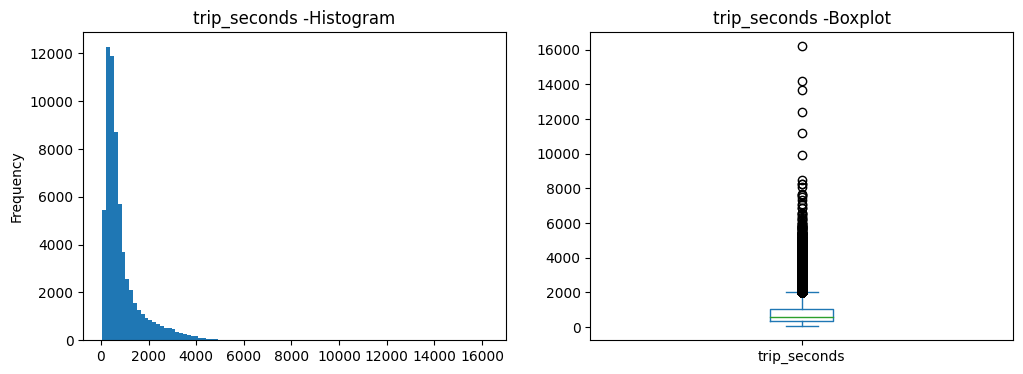

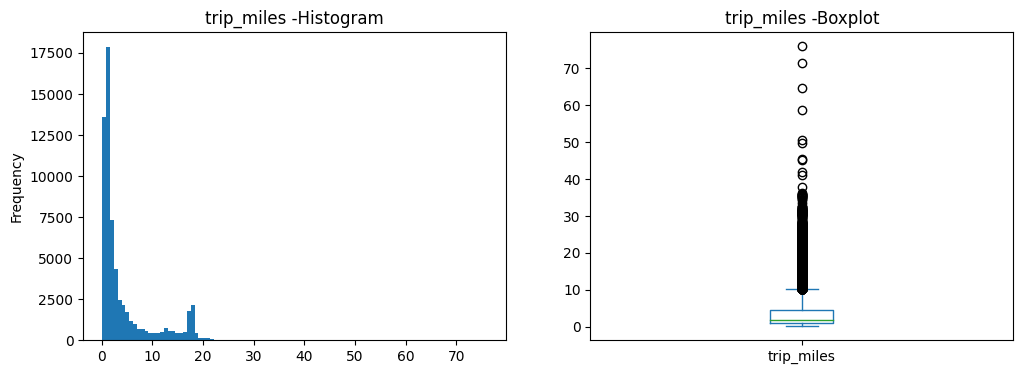

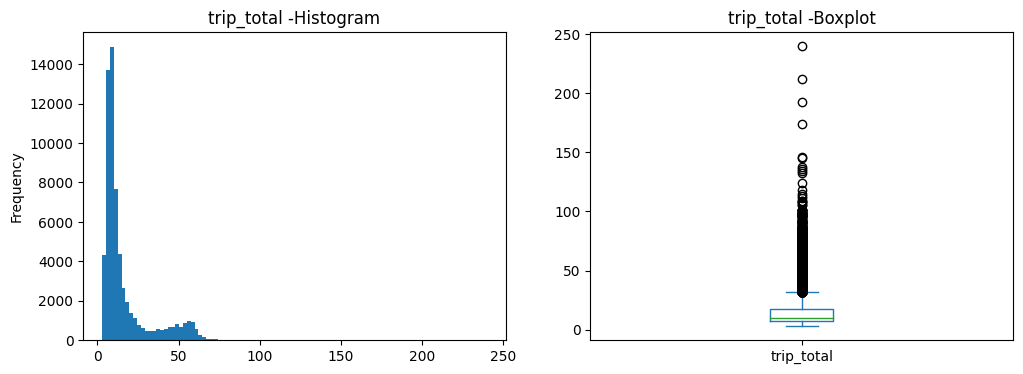

In [32]:
for i in num_cols + [target]:
    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    df[i].plot(kind="hist", bins=100, ax=ax[0])
    ax[0].set_title(str(i) + " -Histogram")
    df[i].plot(kind="box", ax=ax[1])
    ax[1].set_title(str(i) + " -Boxplot")
    plt.show()

#### The field `trip_seconds` describes the time taken for the trip in seconds. For ease of our analysis, let us convert it into hours.

<AxesSubplot:>

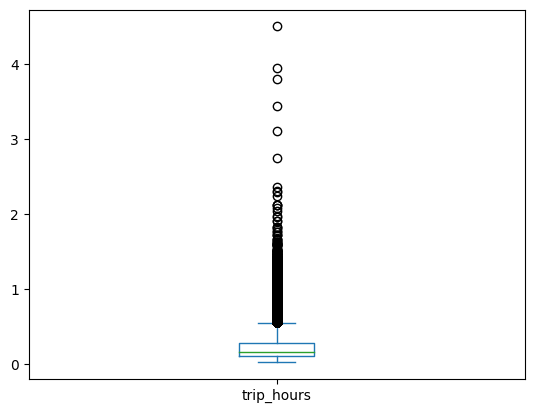

In [33]:
df["trip_hours"] = round(df["trip_seconds"] / 3600, 2)
df["trip_hours"].plot(kind="box")

#### Similarly, another field `trip_speed` can be added by dividing `trip_miles` and `trip_hours` to understand the speed of the trip in miles/hour.

<AxesSubplot:>

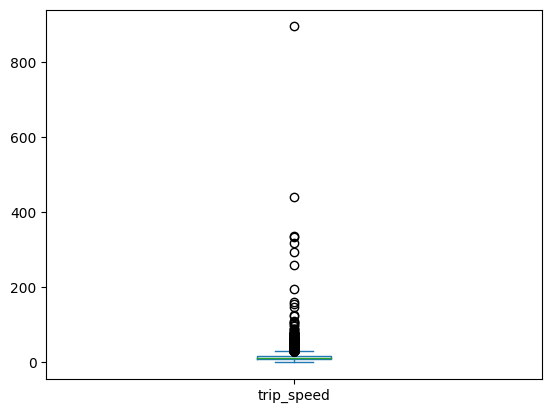

In [34]:
df["trip_speed"] = round(df["trip_miles"] / df["trip_hours"], 2)
df["trip_speed"].plot(kind="box")

#### So far you've only looked at the univariate plots. To better understand the relationship between the variables, a pair-plot can be plotted.

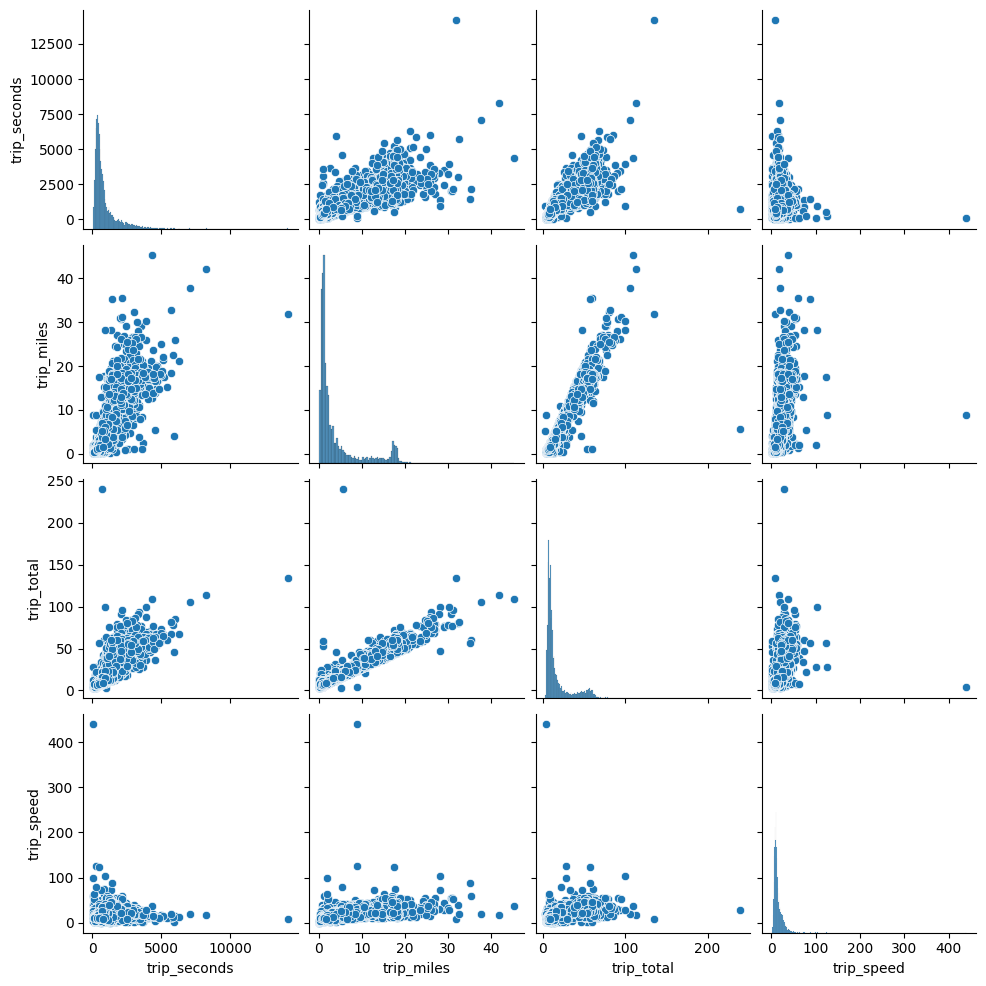

In [35]:
# generate a pairplot for 10K samples
sns.pairplot(
    data=df[["trip_seconds", "trip_miles", "trip_total", "trip_speed"]].sample(10000)
)
plt.show()

From the box plots and the histograms visualized so far, it is evident that there are some outliers causing skewness in the data which perhaps could be removed. Also, you can see some linear relationships between the independent variables considered in the pair-plot. For example, `trip_seconds` and `trip_miles` and the dependant variable `trip_total`.

#### Restrict the data based on the following conditions to remove the outliers in the data to some extent :
- Total charge being at least more than $3.
- Total miles driven greater than 0 and less than 300 miles.
- Total seconds driven at least 1 minute.
- Total hours driven not more than 2 hours.
- Speed of the trip not being more than 70 mph.

These conditions are based on some general assumptions as clearly there were some recording errors like speed being greater than 500 mph and travel-time being more than 5 hours that led to outliers in the data. 

In [36]:
# set constraints to remove outliers
df = df[df["trip_total"] > 3]

df = df[(df["trip_miles"] > 0) & (df["trip_miles"] < 300)]

df = df[df["trip_seconds"] >= 60]

df = df[df["trip_hours"] <= 2]

df = df[df["trip_speed"] <= 70]
df.reset_index(drop=True, inplace=True)
df.shape

(63435, 10)

## Analyze categorical data

#### Further, explore the categorical data by plotting the distribution of all the levels in each field.

(3,)


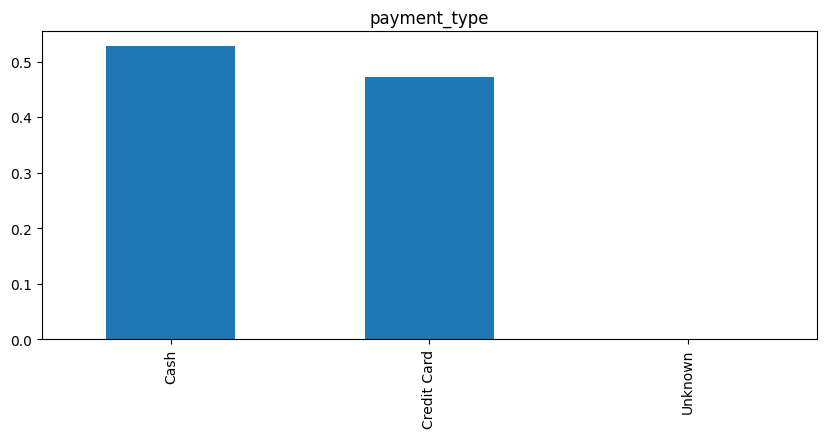

(77,)


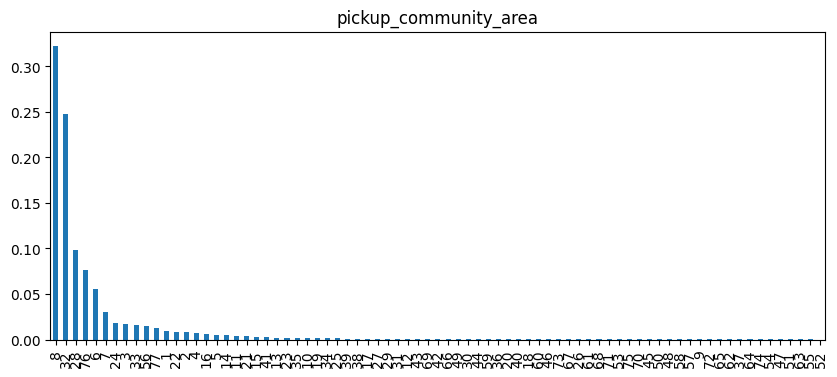

(77,)


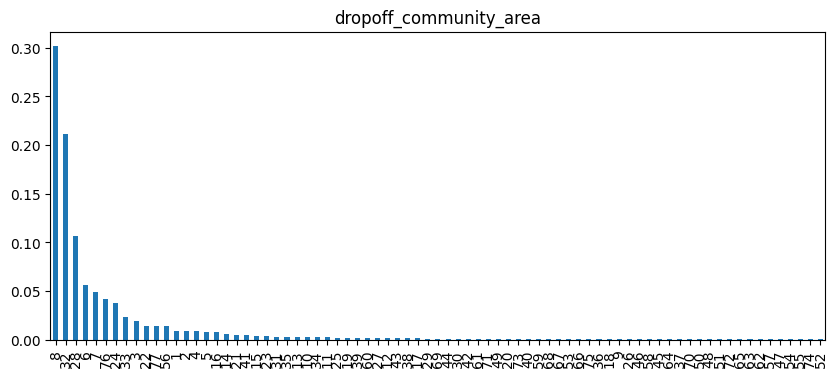

In [37]:
for i in categ_cols:
    print(df[i].unique().shape)
    df[i].value_counts(normalize=True).plot(kind="bar", figsize=(10, 4))
    plt.title(i)
    plt.show()

From the above analysis, one can see that almost 99% of the transaction types are Cash and Credit Card. While there are also other type of transactions, their distribution is negligible. In such a case, the lower distribution levels can be dropped. On the other hand, the total number of pickup and dropoff community areas both seem to have the same levels which make sense. In this case also, one can choose to omit the lower distribution levels but you'd have to make sure that both the fields have the same levels afterward. In the current notebook, keep them as is and proceed with the modeling.

The relationships between the target variable and the categorical fields can be represented through box plots. For each level, the corresponding distribution of the target variable can be identified.

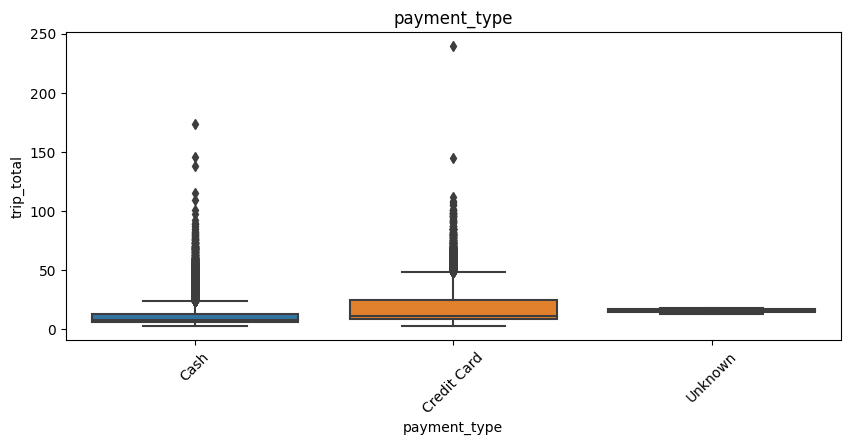

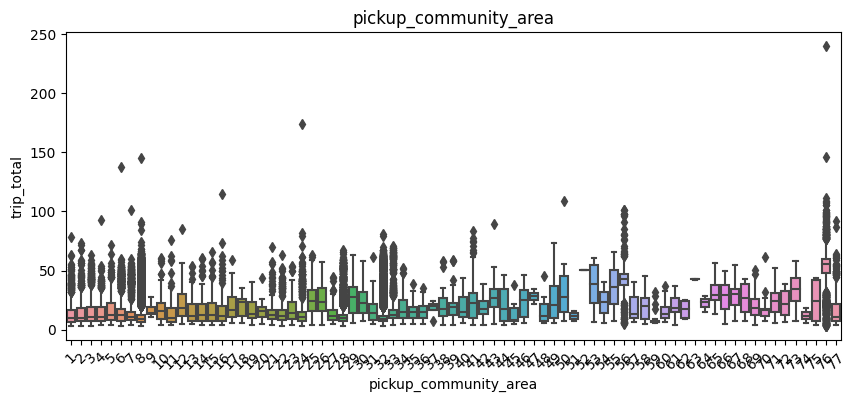

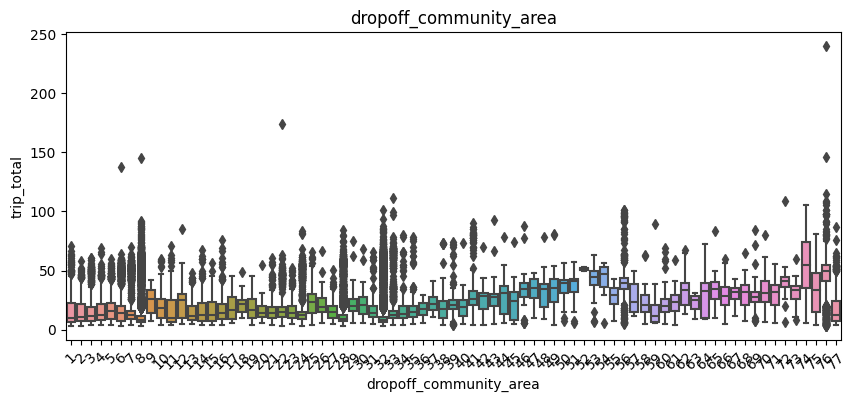

In [214]:
for i in categ_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=i, y=target, data=df)
    plt.xticks(rotation=45)
    plt.title(i)
    plt.show()

There seems to be one case where the `trip_total` is over 3000 and has the same pickup and dropoff community area: 28 is clearly an outlier compared to the rest of the points. This datapoint can be removed.

In [215]:
df = df[df["trip_total"] < 3000].reset_index(drop=True)

#### Keep only the `Credit Card` and `Cash` payment types. Further, encode them by assigning 0 for `Credit Card` and 1 for `Cash` payment types.

In [216]:
# add payment_type
df = df[df["payment_type"].isin(["Credit Card", "Cash"])].reset_index(drop=True)
# encode the payment types
df["payment_type"] = df["payment_type"].apply(
    lambda x: 0 if x == "Credit Card" else (1 if x == "Cash" else None)
)

#### There are also useful timestamp fields in the data. `trip_start_timestamp` represents the start timestamp of the taxi trip and fields like what day of week it was and what hour it was can be derived from it.

In [217]:
df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"])
df["dayofweek"] = df["trip_start_timestamp"].dt.dayofweek
df["hour"] = df["trip_start_timestamp"].dt.hour

Since the current dataset is limited to only a week, if there isn't much variation in the newly derived fields with respect to the target variable, they can be dropped.

#### Plot sum and average of the `trip_total` with respect to the `dayofweek`.

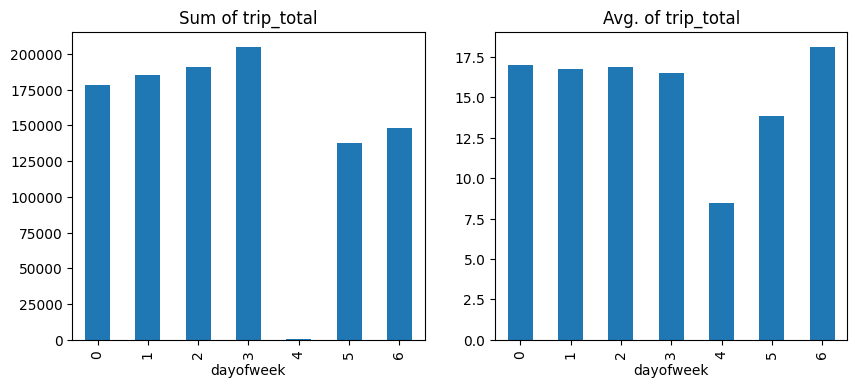

In [218]:
# plot sum and average of trip_total w.r.t the dayofweek
_, ax = plt.subplots(1, 2, figsize=(10, 4))
df[["dayofweek", "trip_total"]].groupby("dayofweek").trip_total.sum().plot(
    kind="bar", ax=ax[0]
)
ax[0].set_title("Sum of trip_total")
df[["dayofweek", "trip_total"]].groupby("dayofweek").trip_total.mean().plot(
    kind="bar", ax=ax[1]
)
ax[1].set_title("Avg. of trip_total")
plt.show()

#### Plot sum and average of the `trip_total` with respect to the `hour`.

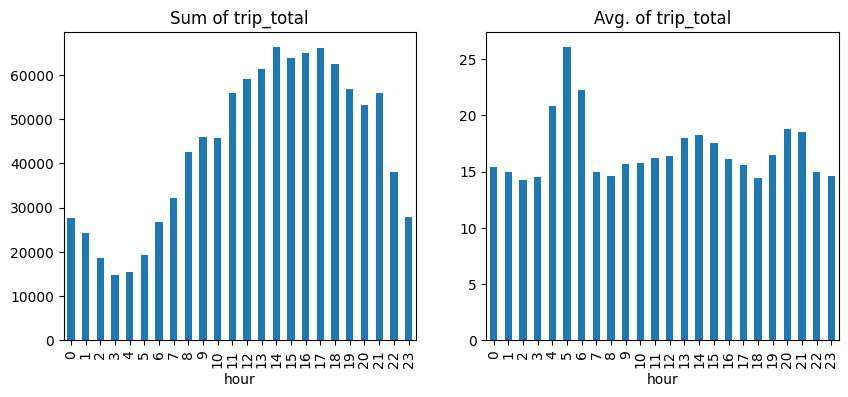

In [219]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
df[["hour", "trip_total"]].groupby("hour").trip_total.sum().plot(kind="bar", ax=ax[0])
ax[0].set_title("Sum of trip_total")
df[["hour", "trip_total"]].groupby("hour").trip_total.mean().plot(kind="bar", ax=ax[1])
ax[1].set_title("Avg. of trip_total")
plt.show()

As these plots don't seem to have constant figures with respect to the target variable across their levels, they can be considered for training. In fact, to simplify things these derived features can be bucketed into fewer levels.

The `dayofweek` field can be bucketed into a binary field considering whether or not it was a weekend. If it is a weekday, the record can be assigned 1, else 0. Similarly, the `hour` field can also be bucketed and encoded. The normal working hours in Chicago can be assumed to be between *8AM*-*10PM* and if the value falls in between the working hours, it can be encoded as 1, else 0.

In [220]:
# bucket and encode the dayofweek and hour
df["dayofweek"] = df["dayofweek"].apply(lambda x: 0 if x in [5, 6] else 1)
df["hour"] = df["hour"].apply(lambda x: 0 if x in [23, 0, 1, 2, 3, 4, 5, 6, 7] else 1)

#### Check the data distribution before training the model.

In [221]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_seconds,63433.0,866.892044,809.252981,61.00,361.00,581.00,1023.00,7095.00
trip_miles,63433.0,4.217735,5.449706,0.10,0.90,1.70,4.60,71.50
trip_total,63433.0,16.482195,15.497888,3.01,7.25,10.00,17.10,239.72
payment_type,63433.0,0.528337,0.499200,0.00,0.00,1.00,1.00,1.00
pickup_community_area,63433.0,24.068434,20.470226,1.00,8.00,24.00,32.00,77.00
dropoff_community_area,63433.0,22.341668,18.476668,1.00,8.00,22.00,32.00,77.00
trip_hours,63433.0,0.240787,0.224801,0.02,0.10,0.16,0.28,1.97
trip_speed,63433.0,14.417411,8.725647,0.11,8.57,11.67,17.67,68.75
dayofweek,63433.0,0.714754,0.451535,0.00,0.00,1.00,1.00,1.00
hour,63433.0,0.803730,0.397178,0.00,1.00,1.00,1.00,1.00


## Divide the data into train and test sets

#### Split the preprocessed dataset into train and test sets so that the linear regression model can be validated on the test set.

In [222]:
cols = [
    "trip_seconds",
    "trip_miles",
    "payment_type",
    "pickup_community_area",
    "dropoff_community_area",
    "dayofweek",
    "hour",
    "trip_speed",
]
x = df[cols].copy()
y = df[target].copy()

# split the data into 75-25% ratio
X_train, X_test, y_train, y_test = train_test_split(
    x, y, train_size=0.75, test_size=0.25, random_state=13
)
X_train.shape, X_test.shape

((47574, 8), (15859, 8))

## Fit a simple linear regression model

#### Fit a linear regression model using scikit-learn's LinearRegression method on the train data.

In [223]:
# Building the regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

#### Print the `R2 score` and `RMSE` values for the model on train and test sets.

In [224]:
# print test R2 score
y_train_pred = reg.predict(X_train)
train_score = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
y_test_pred = reg.predict(X_test)
test_score = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("Train R2-score:", train_score, "Train RMSE:", train_rmse)
print("Test R2-score:", test_score, "Test RMSE:", test_rmse)

Train R2-score: 0.97524676883448 Train RMSE: 2.445342949465596
Test R2-score: 0.9763096081203019 Test RMSE: 2.364461018563396


A low RMSE error and a train and test R2 score of 0.93 suggests that the model is fitted well. Further, the coefficients learned by the model for each of its independent variables can also be checked by checking the `coef_` attribute of the sklearn model. 

#### Check the coefficients learned by the model.

<AxesSubplot:xlabel='col'>

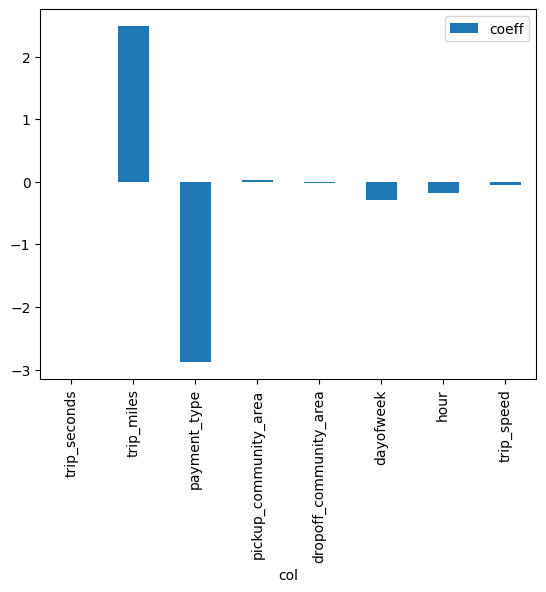

In [225]:
coef_df = pd.DataFrame({"col": cols, "coeff": reg.coef_})
coef_df.set_index("col").plot(kind="bar")

## Save the model and upload to a Cloud Storage bucket

#### To deploy the model on Vertex AI, the model artifacts need to be stored in a Cloud Storage bucket first.

In [226]:
FILE_NAME = "model.pkl"
with open(FILE_NAME, "wb") as file:
    pickle.dump(reg, file)

# Upload the saved model file to Cloud Storage
BLOB_PATH = "taxicab_fare_prediction/"

BLOB_NAME = BLOB_PATH + FILE_NAME

bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename(FILE_NAME)

## Deploy the model on Vertex AI with support for Vertex Explainable AI

Configure Vertex Explainable AI before deploying the model. Learn more about [Configuring Vertex Explainable AI in Vertex AI models](https://cloud.google.com/vertex-ai/docs/explainable-ai/configuring-explanations#scikit-learn-and-xgboost-pre-built-containers).

In [228]:
MODEL_DISPLAY_NAME = "[your-model-display-name]"  # @param {type: "string"}

In [229]:
# If the model display name is not set, choose the default one
if MODEL_DISPLAY_NAME == "[your-model-display-name]":
    MODEL_DISPLAY_NAME = "taxi_fare_prediction_model_azureblob"


ARTIFACT_GCS_PATH = f"{BUCKET_URI}/{BLOB_PATH}"

# Feature-name(Inp_feature) and Output-name(Model_output) can be arbitrary
exp_metadata = {"inputs": {"Input_feature": {}}, "outputs": {"Predicted_taxi_fare": {}}}

#### Create a model resource from the uploaded model with explanation metadata configured.

In [230]:
# Create a Vertex AI model resource with support for Vertex Explainable AI

aiplatform.init(project=PROJECT_ID, location=REGION)

model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=ARTIFACT_GCS_PATH,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest",
    explanation_metadata=exp_metadata,
    explanation_parameters=ExplanationParameters(
        sampled_shapley_attribution=SampledShapleyAttribution(path_count=25)
    ),
)

model.wait()

print(model.display_name)
print(model.resource_name)

Creating Model
Create Model backing LRO: projects/84378298452/locations/us-central1/models/3318108389325668352/operations/83114076808413184
Model created. Resource name: projects/84378298452/locations/us-central1/models/3318108389325668352@1
To use this Model in another session:
model = aiplatform.Model('projects/84378298452/locations/us-central1/models/3318108389325668352@1')
taxi_fare_prediction_model_azureblob
projects/84378298452/locations/us-central1/models/3318108389325668352


### Create an Endpoint resource for the model

#### Set a display name for the endpoint and create the endpoint resource.

In [231]:
ENDPOINT_DISPLAY_NAME = "[your-endpoint-display-name]"  # @param {type: "string"}

# If the display name is not set, choose the default one
if ENDPOINT_DISPLAY_NAME == "[your-endpoint-display-name]":
    ENDPOINT_DISPLAY_NAME = "taxi_fare_prediction_endpoint_azureblob"

endpoint = aiplatform.Endpoint.create(
    display_name=ENDPOINT_DISPLAY_NAME, project=PROJECT_ID, location=REGION
)

print(endpoint.display_name)
print(endpoint.resource_name)

Creating Endpoint
Create Endpoint backing LRO: projects/84378298452/locations/us-central1/endpoints/2862226679193927680/operations/3948891406952562688
Endpoint created. Resource name: projects/84378298452/locations/us-central1/endpoints/2862226679193927680
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/84378298452/locations/us-central1/endpoints/2862226679193927680')
taxi_fare_prediction_endpoint_azureblob
projects/84378298452/locations/us-central1/endpoints/2862226679193927680


### Deploy the model to the created endpoint with the required machine type

#### Set a name for the deployment and deploy the model to the created endpoint.

In [232]:
DEPLOYED_MODEL_NAME = "[your-deployed-model-name]"  # @param {type: "string"}

# If the deployment name is not set, choose the default one
if DEPLOYED_MODEL_NAME == "[your-deployed-model-name]":
    DEPLOYED_MODEL_NAME = "taxi_fare_prediction_deployment_azureblob"

# Set the machine type to n1-standard2
MACHINE_TYPE = "n1-standard-2"

# Deploy the model to the endpoint
model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=DEPLOYED_MODEL_NAME,
    machine_type=MACHINE_TYPE,
)

model.wait()

print(model.display_name)
print(model.resource_name)

Deploying model to Endpoint : projects/84378298452/locations/us-central1/endpoints/2862226679193927680
Deploy Endpoint model backing LRO: projects/84378298452/locations/us-central1/endpoints/2862226679193927680/operations/4817523185081647104
Endpoint model deployed. Resource name: projects/84378298452/locations/us-central1/endpoints/2862226679193927680
taxi_fare_prediction_model_azureblob
projects/84378298452/locations/us-central1/models/3318108389325668352


#### To ensure the model is deployed, the ID of the deployed model can be checked using the `endpoint.list_models()` method.

In [233]:
endpoint.list_models()

[id: "918525416774303744"
 model: "projects/84378298452/locations/us-central1/models/3318108389325668352"
 display_name: "taxi_fare_prediction_deployment_azureblob"
 create_time {
   seconds: 1681874772
   nanos: 478196000
 }
 dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-2"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 explanation_spec {
   parameters {
     sampled_shapley_attribution {
       path_count: 25
     }
   }
   metadata {
     inputs {
       key: "Input_feature"
       value {
       }
     }
     outputs {
       key: "Predicted_taxi_fare"
       value {
       }
     }
   }
 }
 model_version_id: "1"]

## Get explanations from the deployed model

#### For testing the deployed online model, select two instances from the test data as payload.

In [234]:
# format the top 2 test instances as the request's payload
test_json = {"instances": [X_test.iloc[0].tolist(), X_test.iloc[1].tolist()]}

Call the endpoint with the payload request and parse the response for explanations. The explanations consists of attributions on the independent variables used for training the model which are based on the configured attribution method. In this case, we've used the `Sampled Shapely` method which assigns credit for the outcome to each feature, and considers different permutations of the features. This method provides a sampling approximation of exact Shapely values. Further information on the attribution methods for explanations can be found at [Overview of Explainable AI](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview).

##########Explanations##########
 explanation
  attribution
   baseline_output_value: 6.31943915586265
   instance_output_value: 10.39326971745213
   output_display_name: 
   approximation_error: 5.633332848494262e-18
   output_name: Predicted_taxi_fare
   output_index: -1


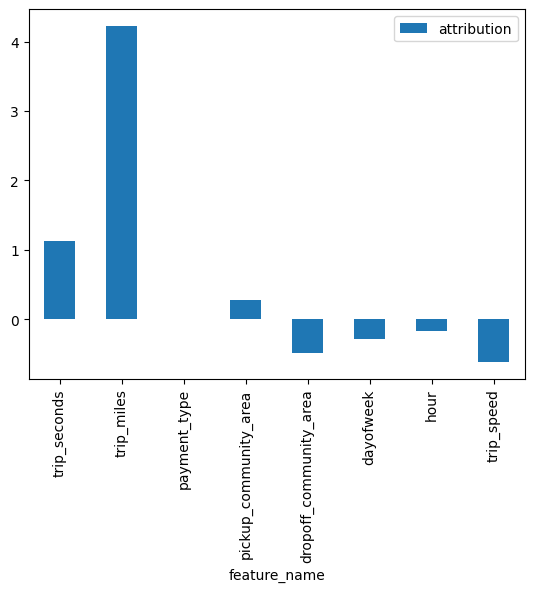

 explanation
  attribution
   baseline_output_value: 6.31943915586265
   instance_output_value: 11.007248692982106
   output_display_name: 
   approximation_error: 3.20512206687027e-18
   output_name: Predicted_taxi_fare
   output_index: -1


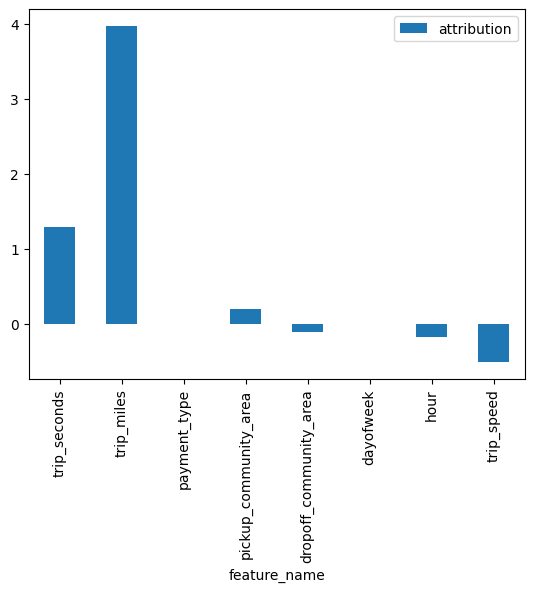

##########Predictions##########
10.39326971745213
11.00724869298211


In [235]:
features = X_train.columns.to_list()


def plot_attributions(attrs):
    """
    Function to plot the features and their attributions for an instance
    """
    rows = {"feature_name": [], "attribution": []}
    for i, val in enumerate(features):
        rows["feature_name"].append(val)
        rows["attribution"].append(attrs["Input_feature"][i])
    attr_df = pd.DataFrame(rows).set_index("feature_name")
    attr_df.plot(kind="bar")
    plt.show()
    return


def explain_tabular_sample(
    project: str, location: str, endpoint_id: str, instances: list
):
    """
    Function to make an explanation request for the specified payload and generate feature attribution plots
    """
    aiplatform.init(project=project, location=location)

    # endpoint = aiplatform.Endpoint(endpoint_id)

    response = endpoint.explain(instances=instances)
    print("#" * 10 + "Explanations" + "#" * 10)
    for explanation in response.explanations:
        print(" explanation")
        # Feature attributions.
        attributions = explanation.attributions

        for attribution in attributions:
            print("  attribution")
            print("   baseline_output_value:", attribution.baseline_output_value)
            print("   instance_output_value:", attribution.instance_output_value)
            print("   output_display_name:", attribution.output_display_name)
            print("   approximation_error:", attribution.approximation_error)
            print("   output_name:", attribution.output_name)
            output_index = attribution.output_index
            for output_index in output_index:
                print("   output_index:", output_index)

            plot_attributions(attribution.feature_attributions)

    print("#" * 10 + "Predictions" + "#" * 10)
    for prediction in response.predictions:
        print(prediction)

    return response


test_json = [X_test.iloc[0].tolist(), X_test.iloc[1].tolist()]
prediction = explain_tabular_sample(PROJECT_ID, REGION, endpoint, test_json)

## Next steps

Since the Chicago Taxi Trips dataset is continuously updating, one can preform the same kind of analysis and model training every time a new set of data is available. The date range can also be increased from a week to a month or more depending on the quality of the data. Most of the steps followed in this notebook would still be valid and can be applied over the new data unless the data is too noisy. In fact, the notebook itself can be scheduled to run at the specified times to retrain the model using the scheduling option of [Vertex AI Workbench's executor](https://console.cloud.google.com/vertex-ai/workbench/list/executions). 

## Clean up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Model
- Endpoint
- Cloud Storage Bucket

In [ ]:
# Undeploy the model
endpoint.undeploy_all()

# Delete the endpoint resource
endpoint.delete()

# Delete the model resource.
model.delete()

# Set this to true only if you'd like to delete your bucket
delete_bucket = False

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI